# FTD Detector
*What does this notebook do?*
- This notebook detects follow-through days (FTDs) in the US stock market.

*What is a follow-through day (FTD)?*
- A trading day where:
  - a major market index like the S&P 500 or Nasdaq rises **at least 1.7% to 2.0%**.
  - The rise is coupled to a **higher trading volume** than the previous day.
  - This happens after a recent low (**market bottom**), and a **rally attempt has already started**.

*What are FTDs used for?*
- Identifying if a rally attempt has gained enough institutional support to become a sustained uptrend.

*What is a rally attempt?*
- The first sign that an index may be bottoming out after a correction.
- It's the initial uptick in price after a recent low, but not yet a confirmed uptrend.
- Day 1 of a rally attempt is the first day an index closes higher than the previous day.

*What is the precise criteria for a follow-through day?*
- They occur 4-10 days after a market low or a rally attempt has begun.
  - Day 1 is the rally day where the index closes higher than the previous day.
  - The FTD must occur between **Day 4 and Day 10**, inclusive.
- The major index rises at least 1.7% to 2.0%.
- Volume is higher than the previous day (sign of institutional accumulation).
- Price must close higher than the previous day.

*Why are FTDs important?*
- They signal the potential beginning to a new bull market or tradeable rally.
- They help confirm that a rally isn't just a short-term bounce, but has institutional backing.

*What are some caveats about FTDs?*
- Not all FTDs lead to sustained rallies.
- FTDs work best in clear downtrend-to-uptrend transitions and *not* sideways or choppy markets.
- Institutional investors watch this signal, so it can have self-reinforcing impact.




In [101]:
from typing import Dict, List, Tuple

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [102]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 12

In [103]:
def get_market_data(ticker: str, period: str = "3mo") -> pd.DataFrame:
    """Fetch market data for a specified ticker.

    Args:
        ticker (str): The ticker symbol (e.g. "^GSPC" for S&P 500, "^IXIC" for NASDAQ).
        period (str): The time period to fetch data for.

    Returns:
        pd.DataFrame: Historical price data.
    """
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)

    # Calculate some standard metrics.
    df["Daily_Change"] = df["Close"].pct_change() * 100
    df["Up_Down"] = df["Daily_Change"].apply(lambda x: "Up" if x > 0 else "Down")
    df["Volume_Change"] = df["Volume"].pct_change() * 100
    df["MA50"] = df["Close"].rolling(window=50).mean()

    # Calculate higher-volume days (compared to the 10-day rolling average).
    df["10d_Avg_Volume"] = df["Volume"].rolling(window=10).mean()
    df["Volume_vs_Avg"] = (df["Volume"] / df["10d_Avg_Volume"]) * 100 - 100

    return df

In [104]:
def identify_follow_through_days(
    df: pd.DataFrame,
    price_threshold: float = 1.7,
    volume_threshold: float = 15.0,
    ftd_window_start: int = 4,
    ftd_window_end: int = 10,
) -> Tuple[pd.DataFrame, List[Dict], str]:
    """Identify rally attempts and follow-through days (FTDs).

    Args:
        df (pd.DataFrame): Market data.
        price_threshold (float): Minimum price change percentage to qualify as a follow
            through day (default +1.7%).
        volume_threshold (float): Minimum volume increase percentage vs 10-day average
            for FTD qualification (default +1%).
        ftd_window_start (int): Min day after rally to start check for FTD (default 4).
        ftd_window_end (int): Max day after rally to allow FTD (default 10).

    Returns:
        Tuple(pd.DataFrame, List[Dict], str): DataFrame with rally attempts and FTDs,
            contextual details, and text analysis.
    """
    # Create a copy of the dataframe to avoid modifying the original.
    analysis_df = df.copy()

    # Find market bottoms (potential rally attempts). Here:
    #   `.shift()` is used to access data from adjacent rows.
    #   `analysis_df['Low'].shift(1)` refers to the previous day's low price.
    #   `analysis_df['Low'].shift(-1) refers to the next day's low price.
    # This combination identifies a point where:
    #   Today's low is equal to the 5-day low (market bottom).
    #   Today's low is lower than yesterday's low (downward movement).
    #   Today's low is lower than tomorrow's low (reversal begins).
    analysis_df["Low_5d"] = analysis_df["Low"].rolling(window=5).min()
    analysis_df["Is_Bottom"] = (
        (analysis_df["Low"] == analysis_df["Low_5d"])
        & (analysis_df["Low"].shift(1) > analysis_df["Low"])
        & (analysis_df["Low"].shift(-1) > analysis_df["Low"])
    )

    # Find rally attempts (first up day after a bottom).
    rally_attempts_mask = (
        analysis_df["Is_Bottom"].shift(1)
        & (analysis_df["Up_Down"] == "Up")
    )
    rally_attempts = list(analysis_df.index[rally_attempts_mask])

    # Mark rally attempts in the dataframe.
    analysis_df["Rally_Attempt"] = False
    analysis_df.loc[rally_attempts, "Rally_Attempt"] = True

    # Prepare to identify FTDs.
    ftds = []
    ftd_details = []
    for rally_date in rally_attempts:
        # Get the index location of the rally attempt.
        rally_idx = analysis_df.index.get_loc(rally_date)

        # Loop from `ftd_window_start` to `ftd_window_end` (inclusive).
        for i in range(ftd_window_start - 1, ftd_window_end):
            check_idx = rally_idx + i
            if check_idx >= len(analysis_df):
                break
            check_date = analysis_df.index[check_idx]
            row = analysis_df.loc[check_date]

            # Check FTD criteria: Up day with significant price and volume increase.
            if (
                row["Daily_Change"] >= price_threshold
                and row["Volume_vs_Avg"] >= volume_threshold
                and row["Up_Down"] == "Up"
            ):
                ftds.append(check_date)
                ftd_details.append(
                    {
                        "Date": check_date,
                        "Rally_Start": rally_date,
                        "Days_From_Rally": i,
                        "Price_Change": row["Daily_Change"],
                        "Volume_Change": row["Volume_vs_Avg"],
                    }
                )
                break

    # Mark follow through days in the dataframe.
    analysis_df["Follow_Through_Day"] = False
    for date in ftds:
        analysis_df.loc[date, "Follow_Through_Day"] = True

    # Create analysis text.
    analysis_text = []

    if rally_attempts:
        latest_rally = max(rally_attempts)
        latest_rally_idx = analysis_df.index.get_loc(latest_rally)
        days_since_rally = len(analysis_df) - latest_rally_idx - 1

        msg = (f"Latest rally attempt: {latest_rally.strftime('%Y-%m-%d')}"
               f" ({days_since_rally} days ago)")
        analysis_text.append(msg)

        # Check if FTD occurred for the latest rally.
        latest_ftd = next(
            (ftd for ftd in ftd_details if ftd["Rally_Start"] == latest_rally), None
        )

        if latest_ftd:
            msg = (
                f"Follow Through Day CONFIRMED on"
                f" {latest_ftd['Date'].strftime('%Y-%m-%d')}"
                f"\n> {latest_ftd['Days_From_Rally']} days after rally attempt"
                f"\n> Price change: +{latest_ftd['Price_Change']:.2f}%"
                f"\n> Vol change: +{latest_ftd['Volume_Change']:.2f}% above 10-day avg"
                f"\nCurrent market status: CONFIRMED UPTREND"
            )
            analysis_text.append(msg)
        else:
            if days_since_rally <= ftd_window_end:
                msg = (
                    f"No Follow Through Day yet. Still within window:"
                    f" (Day {ftd_window_start}–{ftd_window_end})"
                    f"\nCurrent market status: RALLY ATTEMPT (waiting for confirmation)"
                )
                analysis_text.append(msg)
            else:
                msg = (
                    f"No Follow Through Day detected within window:"
                    f" (Day {ftd_window_start}–{ftd_window_end})"
                    f"\nCurrent market status: FAILED RALLY ATTEMPT"
                )
                analysis_text.append(msg)
    else:
        msg = "No recent rally attempts detected in the analyzed period."
        analysis_text.append(msg)

    return analysis_df, ftd_details, "\n".join(analysis_text)

In [105]:
def plot_market_analysis(
    df: pd.DataFrame,
    analysis_df: pd.DataFrame,
    ticker_name: str,
    ftd_details: List[Dict],
) -> Figure:
    """Create a visualization of market data for rally attempts and follow-through days.

    Args:
        df (pd.DataFrame): Original market data.
        analysis_df (pd.DataFrame): Analysis data with rally attempts and FTDs.
        ticker_name (str): Name of the ticker for plot titles.
        ftd_details (list): Details of follow through days.

    Returns:
        Figure: The created figure.
    """
    fig = plt.figure(figsize=(14, 10))
    gs = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])

    # Price Chart.
    ax1 = plt.subplot(gs[0])
    ax1.plot(df.index, df["Close"], label="Close Price", color="#1f77b4", linewidth=2)
    ax1.plot(
        df.index,
        df["MA50"],
        label="50-day MA",
        color="#ff7f0e",
        linestyle="--",
        alpha=0.8,
    )

    # Mark rally attempts and follow through days on the Price Chart.
    rally_dates = analysis_df[analysis_df["Rally_Attempt"]].index
    ftd_dates = analysis_df[analysis_df["Follow_Through_Day"]].index
    for date in rally_dates:
        ax1.axvline(x=date, color="green", linestyle="--", alpha=0.5)
    for date in ftd_dates:
        ax1.axvline(x=date, color="blue", linestyle="-", alpha=0.5)

    # Volume Chart.
    ax2 = plt.subplot(gs[1], sharex=ax1)
    colors = ["red" if row["Daily_Change"] < 0 else "green" for _, row in df.iterrows()]
    ax2.bar(df.index, df["Volume"], color=colors, alpha=0.6)
    ax2.plot(
        df.index,
        df["10d_Avg_Volume"],
        color="black",
        linestyle="-",
        label="10-day Avg Volume",
    )

    # Daily Change Chart.
    ax3 = plt.subplot(gs[2], sharex=ax1)
    colors = ["red" if x < 0 else "green" for x in df["Daily_Change"]]
    ax3.bar(df.index, df["Daily_Change"], color=colors, alpha=0.6)
    ax3.axhline(y=0, color="black", linestyle="-", alpha=0.3)

    # Highlight FTD days on the Volume and Daily Change charts.
    for date in ftd_dates:
        ax2.bar(date, df.loc[date, "Volume"], color="blue", alpha=0.8)
        ax3.bar(date, df.loc[date, "Daily_Change"], color="blue", alpha=0.8)

    # Format x-axis.
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    ax3.xaxis.set_major_locator(mdates.DayLocator())  # Set a tick for each day.
    ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90, fontsize=8)

    # Set labels and titles.
    ax1.set_title(
        f"{ticker_name} Analysis with Follow Through Day Detection", fontsize=16
    )
    ax1.set_ylabel("Price ($)", fontsize=12)
    ax2.set_ylabel("Volume", fontsize=12)
    ax3.set_ylabel("Daily Change (%)", fontsize=12)
    ax3.set_xlabel("Date", fontsize=12)

    # Create a single, consolidated legend for all elements.
    legend_elements_price = [
        Line2D([0], [0], color="#1f77b4", lw=2, label="Close Price"),
        Line2D(
            [0],
            [0],
            color="#ff7f0e",
            lw=2,
            linestyle="--",
            alpha=0.8,
            label="50-day MA Close Price",
        ),
        Line2D(
            [0],
            [0],
            color="green",
            lw=2,
            linestyle="--",
            alpha=0.5,
            label="Rally Attempt",
        ),
        Line2D([0], [0], color="blue", lw=2, linestyle="-", alpha=0.5, label="FTD"),
    ]
    # Attach the consolidated legend to the Price Chart (ax1) at the lower-left corner.
    ax1.legend(handles=legend_elements_price, loc="lower left", ncol=2, frameon=False)
    legend_elements_vol = [
        Patch(facecolor="green", alpha=0.6, label="Positive Change"),
        Patch(facecolor="red", alpha=0.6, label="Negative Change"),
        Line2D([0], [0], color="black", lw=2, linestyle="-", label="10-Day Volume MA"),
        Patch(facecolor="blue", alpha=0.8, label="FTD Bar"),
    ]
    ax2.legend(handles=legend_elements_vol, loc="upper left", ncol=2, frameon=False)
    plt.tight_layout()

    return fig

In [106]:
def analyze_ticker(
    ticker: str,
    ticker_name: str,
    period: str = "3mo",
    price_threshold: float = 1.0,
    volume_threshold: float = 20,
) -> Tuple[str, Figure, pd.DataFrame, pd.DataFrame]:
    """Run a full follow-through day analysis for a given ticker.

    Parameters:
        ticker (str): The ticker symbol.
        ticker_name (str): The display name for the ticker.
        period (str): Time period to analyze.
        price_threshold (float): Minimum price change for FTD.
        volume_threshold (float): Minimum volume increase for FTD.

    Returns:
        Tuple(str, Figure, pd.DataFrame, pd.DataFrame): Analysis text, visualization,
            original price data, and analysis data.
    """
    df = get_market_data(ticker, period)
    analysis_df, ftd_details, analysis_text = identify_follow_through_days(
        df, price_threshold, volume_threshold
    )
    fig = plot_market_analysis(df, analysis_df, ticker_name, ftd_details)
    return analysis_text, fig, df, analysis_df

In [107]:
def main():
    sp500_analysis, _, sp500_df, sp500_analysis_df = analyze_ticker(
        "^GSPC", "S&P 500", period="3mo"
    )
    nasdaq_analysis, _, _, nasdaq_analysis_df = analyze_ticker(
        "^IXIC", "NASDAQ Composite", period="3mo"
    )
    print("[S&P 500]")
    print(sp500_analysis)
    print("-" * 50)
    print("[NASDAQ]")
    print(nasdaq_analysis)
    print("-" * 50)
    print("[MARKET STATUS SUMMARY]")

    latest_data_date = sp500_df.index[-1].strftime("%Y-%m-%d")
    print(f"Latest data as of: {latest_data_date}")

    # Determine if we're in a confirmed uptrend based on both indices.
    sp500_confirmed = sp500_analysis_df["Follow_Through_Day"].any()
    nasdaq_confirmed = nasdaq_analysis_df["Follow_Through_Day"].any()

    if sp500_confirmed and nasdaq_confirmed:
        print("MARKET STATUS: CONFIRMED UPTREND in both S&P 500 and NASDAQ")
    elif sp500_confirmed:
        print("MARKET STATUS: CONFIRMED UPTREND in S&P 500 only")
    elif nasdaq_confirmed:
        print("MARKET STATUS: CONFIRMED UPTREND in NASDAQ only")
    else:
        print("MARKET STATUS: NO CONFIRMED UPTREND")

In [108]:
def analyze_custom_ticker(ticker: str, name: str = None, period: str = "3mo") -> None:
    """Analyze a custom ticker for follow-through day analysis.

    Args:
        ticker (str): The ticker symbol.
        name (str): Display name (optional).
        period (str): Time period to analyze.

    Returns:
        None (displays analysis and chart).
    """
    if name is None:
        name = ticker

    analysis, _, _, _ = analyze_ticker(ticker, name, period)

    print("-" * 50)
    print(f"[{name.upper()} ANALYSIS]")
    print(analysis)

[S&P 500]
Latest rally attempt: 2025-04-01 (5 days ago)
No Follow Through Day yet. Still within window: (Day 4–10)
Current market status: RALLY ATTEMPT (waiting for confirmation)
--------------------------------------------------
[NASDAQ]
Latest rally attempt: 2025-04-01 (5 days ago)
No Follow Through Day yet. Still within window: (Day 4–10)
Current market status: RALLY ATTEMPT (waiting for confirmation)
--------------------------------------------------
[MARKET STATUS SUMMARY]
Latest data as of: 2025-04-08
MARKET STATUS: NO CONFIRMED UPTREND
--------------------------------------------------
[NVIDIA CORPORATION ANALYSIS]
Latest rally attempt: 2025-04-01 (5 days ago)
Follow Through Day CONFIRMED on 2025-04-07
> 4 days after rally attempt
> Price change: +3.53%
> Vol change: +93.85% above 10-day avg
Current market status: CONFIRMED UPTREND


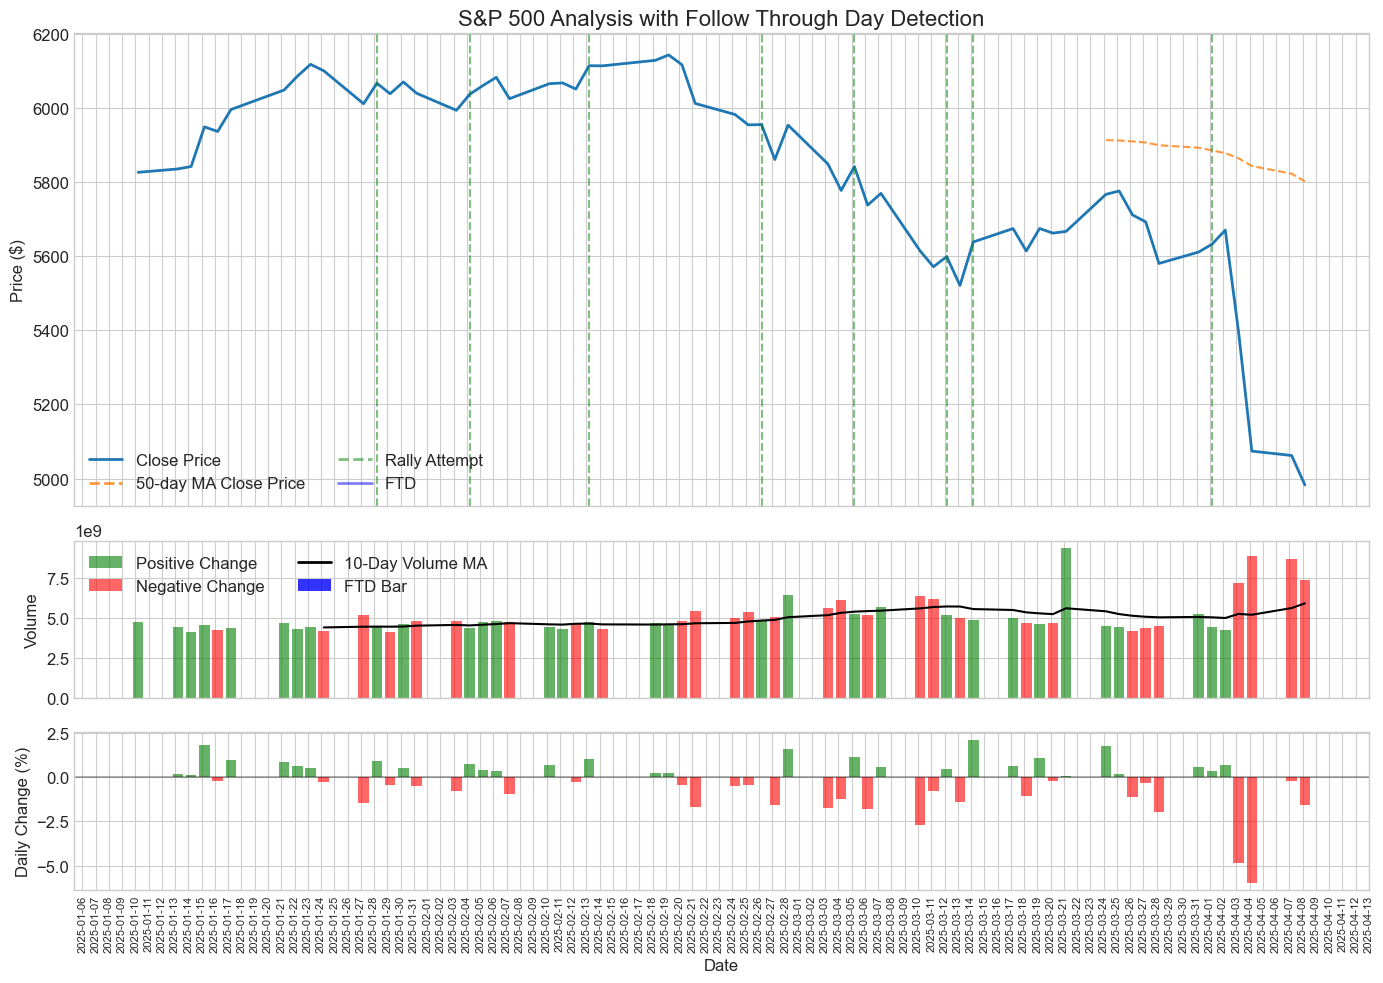

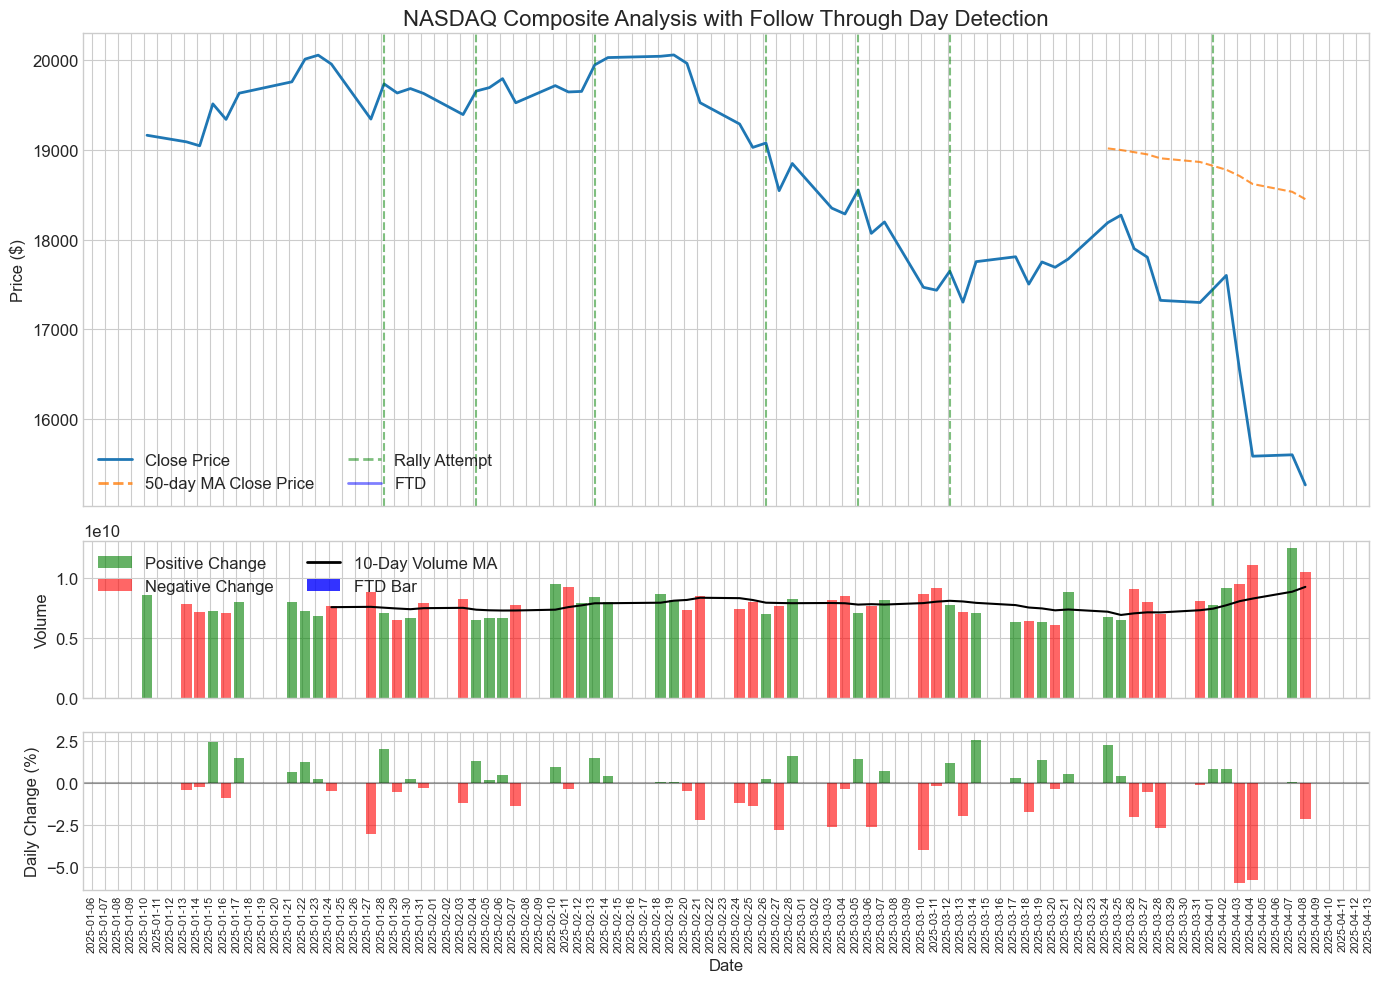

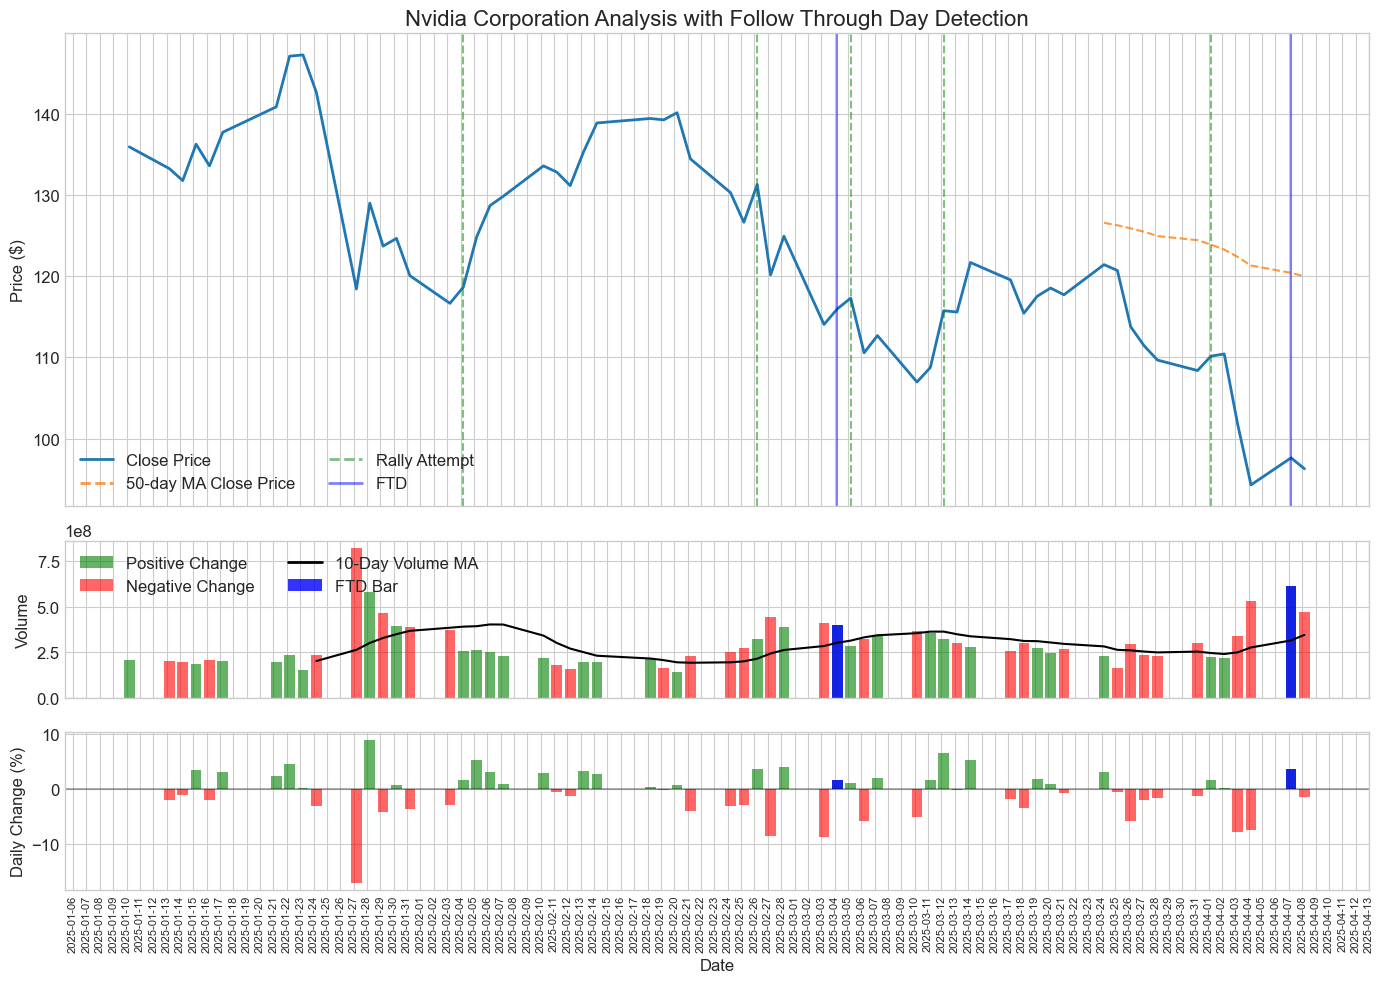

In [109]:
# Run the main analysis.
if __name__ == "__main__":
    main()
    # Uncomment below to analyze a custom ticker:
    analyze_custom_ticker("NVDA", "Nvidia Corporation", period="3mo")